In [22]:
# Libraries used
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import openmeteo_requests
import pandas as pd
import pickle
import requests_cache
from retry_requests import retry
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
# Satellite Data
hotspots = gpd.read_file("./data_2024/hotspots/fire_archive_M-C61_629919.shp")
# Weather Data
perimeter = gpd.read_file("./data_2024/perimeter/cc_apt_buf.shp")

# print(hotspots.head(3))
# print(perimeter.head(3))

   LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK   ACQ_DATE ACQ_TIME SATELLITE  \
0   56.1487  -119.4577       318.9   1.6    1.2 2024-01-01     2139      Aqua   
1   52.5329  -112.4523       301.5   1.0    1.0 2024-01-02     2041      Aqua   
2   52.2269  -112.6734       307.6   1.0    1.0 2024-01-02     2041      Aqua   

  INSTRUMENT  CONFIDENCE VERSION  BRIGHT_T31   FRP DAYNIGHT  TYPE  \
0      MODIS          53   61.03       266.8  45.0        D     0   
1      MODIS          48   61.03       269.5  10.3        D     0   
2      MODIS          62   61.03       270.3  14.0        D     0   

                    geometry  
0  POINT (-119.4577 56.1487)  
1  POINT (-112.4523 52.5329)  
2  POINT (-112.6734 52.2269)  
        UID  HCOUNT     AREA            FIRSTDATE             LASTDATE  \
0  32269292      47  112.454  2024-07-11 19:28:00  2024-07-24 10:32:00   
1  32269069     104  710.313  2024-07-14 20:12:00  2024-08-02 18:36:00   
2  32269201      11  134.130  2024-04-14 17:45:00  2

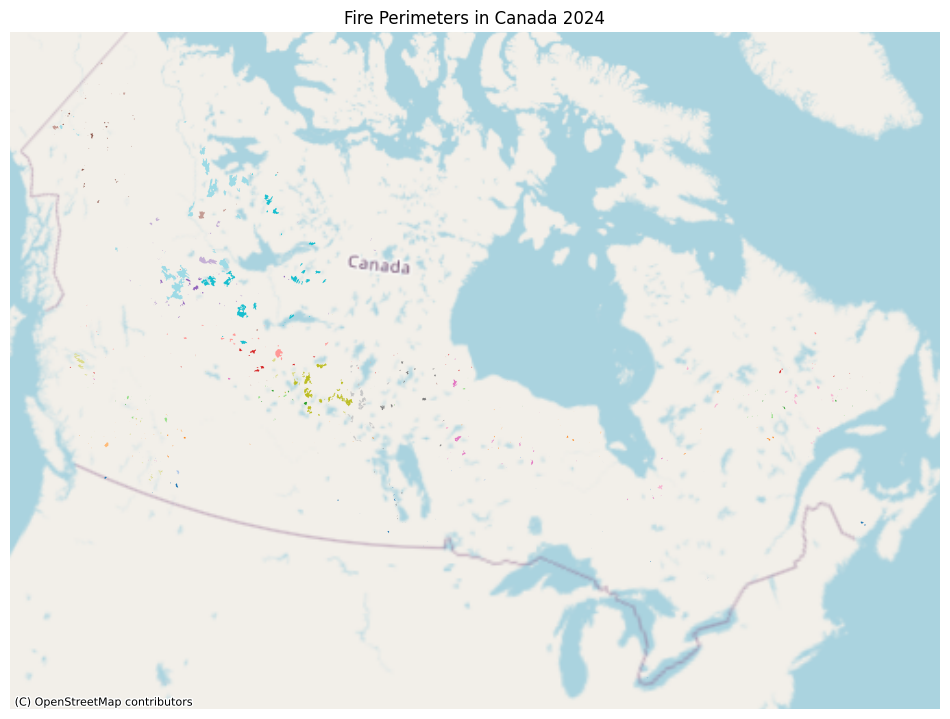

In [24]:
# Set + Match Coordinate Reference System (CRS) for both files
if hotspots.crs is None:
    hotspots.set_crs(epsg = 4326, inplace = True)  # WGS84 lat/lon

if perimeter.crs is None:
    perimeter.set_crs(epsg = 3978, inplace = True)  # NAD_1983_Canada_Atlas_Lambert (Canada specific)

hotspots = hotspots.to_crs(perimeter.crs)

# Find hotspots intersecting fire perimeters
hotspots_with_perimeter = gpd.sjoin(hotspots, perimeter, how = "inner", predicate = "intersects")

# Combine ACQ_DATE and ACQ_TIME into a single dataframe column
hotspots_with_perimeter["ACQ_TIME"] = hotspots_with_perimeter["ACQ_TIME"].astype(str).str.zfill(4)
hotspots_with_perimeter["ACQ_DATETIME"] = pd.to_datetime(
    hotspots_with_perimeter["ACQ_DATE"].astype(str) + " " +
    hotspots_with_perimeter["ACQ_TIME"].str[:2] + ":" +
    hotspots_with_perimeter["ACQ_TIME"].str[2:], 
    format="%Y-%m-%d %H:%M"
)

# Filter hotspots that fall within fire perimeter's date range
hotspots_with_perimeter = hotspots_with_perimeter[
    (hotspots_with_perimeter["ACQ_DATETIME"] >= hotspots_with_perimeter["FIRSTDATE"]) &
    (hotspots_with_perimeter["ACQ_DATETIME"] <= hotspots_with_perimeter["LASTDATE"])
]

counts = hotspots_with_perimeter.groupby("UID").size().reset_index(name = "hotspot_count")

# Add a hotspot_count column for keeping track of how many hotspots there are per fire
perimeter_with_counts = perimeter.merge(counts, on = "UID", how = "left")
perimeter_with_counts["hotspot_count"] = perimeter_with_counts["hotspot_count"].fillna(0).astype(int)

# Plot fire perimeters
fig, ax = plt.subplots(figsize = (12, 12))
perimeter_with_counts.plot(
    ax = ax,
    column = "UID",
    categorical = True,
    legend = False,
    cmap = "tab20"
)

cx.add_basemap(ax, crs = perimeter_with_counts.crs, source = cx.providers.OpenStreetMap.Mapnik)

ax.set_title("Fire Perimeters in Canada 2024")
ax.axis("off")
plt.show()

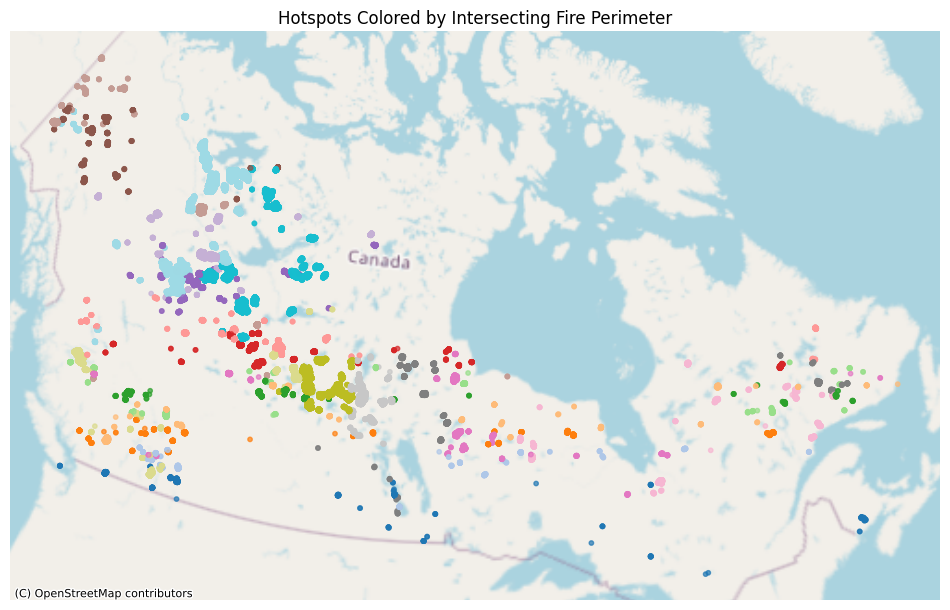

In [25]:
# Plot hotspot points, coloured by the fire perimeter they intersect
fig, ax = plt.subplots(figsize = (12, 12))

hotspots_with_perimeter.plot(
    ax = ax,
    column = "UID",
    categorical = True,
    legend = False,
    cmap = "tab20",
    markersize = 10,
    alpha = 0.7
)

ax.set_title("Hotspots Colored by Intersecting Fire Perimeter")
ax.axis("off")
cx.add_basemap(ax, crs = perimeter_with_counts.crs, source = cx.providers.OpenStreetMap.Mapnik)
plt.show()

In [26]:
training_data = hotspots_with_perimeter[["LATITUDE", "LONGITUDE", "BRIGHTNESS", "ACQ_DATE", "ACQ_TIME", 
                                         "FRP", "UID", "HCOUNT", "AREA", "FIRSTDATE", "LASTDATE"]]

# Filter out fire groups with 2 or less hotspots
training_data = training_data[training_data["UID"].map(training_data["UID"].value_counts()) > 2]

grouped = training_data.groupby(["UID", "ACQ_DATE"])

def max_and_min(g):
    max_lat_row = g.loc[g["LATITUDE"].idxmax()]
    min_lat_row = g.loc[g["LATITUDE"].idxmin()]
    max_lon_row = g.loc[g["LONGITUDE"].idxmax()]
    min_lon_row = g.loc[g["LONGITUDE"].idxmin()]
    
    return pd.Series({
        "LAT_MAX_LAT": max_lat_row["LATITUDE"],
        "LAT_MAX_LON": max_lat_row["LONGITUDE"],
        "LAT_MIN_LAT": min_lat_row["LATITUDE"],
        "LAT_MIN_LON": min_lat_row["LONGITUDE"],
        "LON_MAX_LAT": max_lon_row["LATITUDE"],
        "LON_MAX_LON": max_lon_row["LONGITUDE"],
        "LON_MIN_LAT": min_lon_row["LATITUDE"],
        "LON_MIN_LON": min_lon_row["LONGITUDE"],
        "ACQ_TIME_MAX_LAT": max_lat_row["ACQ_TIME"],
        "ACQ_TIME_MIN_LAT": min_lat_row["ACQ_TIME"],
        "ACQ_TIME_MAX_LON": max_lon_row["ACQ_TIME"],
        "ACQ_TIME_MIN_LON": min_lat_row["ACQ_TIME"]
    })

training_data = grouped.apply(max_and_min).reset_index()

# Add next day's min/max lat/lon values for each fire (UID)
training_data["NEXT_LAT_MAX_LAT"] = training_data.groupby("UID")["LAT_MAX_LAT"].shift(-1)
training_data["NEXT_LAT_MAX_LON"] = training_data.groupby("UID")["LAT_MAX_LON"].shift(-1)
training_data["NEXT_LAT_MIN_LAT"] = training_data.groupby("UID")["LAT_MIN_LAT"].shift(-1)
training_data["NEXT_LAT_MIN_LON"] = training_data.groupby("UID")["LAT_MIN_LON"].shift(-1)
training_data["NEXT_LON_MAX_LAT"] = training_data.groupby("UID")["LON_MAX_LAT"].shift(-1)
training_data["NEXT_LON_MAX_LON"] = training_data.groupby("UID")["LON_MAX_LON"].shift(-1)
training_data["NEXT_LON_MIN_LAT"] = training_data.groupby("UID")["LON_MIN_LAT"].shift(-1)
training_data["NEXT_LON_MIN_LON"] = training_data.groupby("UID")["LON_MIN_LON"].shift(-1)

# Drop rows with no next-day location values
training_data = training_data.dropna(subset=["NEXT_LAT_MAX_LAT", "NEXT_LAT_MAX_LON", 
                                             "NEXT_LAT_MIN_LAT", "NEXT_LAT_MIN_LON",
                                             "NEXT_LON_MAX_LAT", "NEXT_LON_MAX_LON",
                                             "NEXT_LON_MIN_LAT", "NEXT_LON_MIN_LON"])

C:\Users\marku\AppData\Local\Temp\ipykernel_9928\2675786351.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  training_data = grouped.apply(max_and_min).reset_index()


In [ ]:
# Add weather data to table
cache_session = requests_cache.CachedSession(".cache", expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

points = ["LAT_MAX", "LAT_MIN", "LON_MAX", "LON_MIN"]
weather_features = ["temperature_2m", "relative_humidity_2m", "wind_speed_10m", "wind_direction_10m", "precipitation"]
weather_columns = [f"{pt}_{feat}" for pt in points for feat in weather_features]

# Initialize empty columns for weather data
for col in weather_columns:
    training_data[col] = None

# Iterate through each training row and fetch weather from open-meteo API
for index, row in training_data.iterrows():
    lat_list = [row.get(f"{pt}_LAT") for pt in points]
    lon_list = [row.get(f"{pt}_LON") for pt in points]
    date = pd.to_datetime(row["ACQ_DATE"]).strftime("%Y-%m-%d")

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat_list,
        "longitude": lon_list,
        "start_date": [date] * 4,
        "end_date": [date] * 4,
        "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m,wind_direction_10m,precipitation",
        "timezone": ["GMT"] * 4
    }
    response = openmeteo.weather_api(url, params = params)

    acq_time_map = {
        "LAT_MAX": "ACQ_TIME_MAX_LAT",
        "LAT_MIN": "ACQ_TIME_MIN_LAT",
        "LON_MAX": "ACQ_TIME_MAX_LON",
        "LON_MIN": "ACQ_TIME_MIN_LON"
    }

    for i, point in enumerate(points):
        weather_data = response[i].Hourly()
        acq_col = acq_time_map[point]
        current_hour = int(str(row[acq_col]).zfill(4)[:2])  # Zero-pad and extract hour

        values = {
            "temperature_2m": weather_data.Variables(0).ValuesAsNumpy()[current_hour],
            "relative_humidity_2m": weather_data.Variables(1).ValuesAsNumpy()[current_hour],
            "wind_speed_10m": weather_data.Variables(2).ValuesAsNumpy()[current_hour],
            "wind_direction_10m": weather_data.Variables(3).ValuesAsNumpy()[current_hour],
            "precipitation": weather_data.Variables(4).ValuesAsNumpy()[current_hour]
        }

# Assign weather values to the training row
        for stat, val in values.items():
            training_data.at[index, f"{point}_{stat}"] = val

# print(training_data.head())

        UID   ACQ_DATE  LAT_MAX_LAT  LAT_MAX_LON  LAT_MIN_LAT  LAT_MIN_LON  \
0  32267271 2024-08-05      47.3180     -80.8734      47.3180     -80.8734   
1  32267271 2024-08-09      47.3432     -80.8781      47.3332     -80.8737   
3  32267297 2024-05-13      49.1239     -96.8370      49.1239     -96.8370   
4  32267297 2024-07-11      49.1201     -96.8333      49.1201     -96.8333   
5  32267297 2024-07-30      49.1196     -96.8336      49.1177     -96.8471   

   LON_MAX_LAT  LON_MAX_LON  LON_MIN_LAT  LON_MIN_LON  ...  \
0      47.3180     -80.8734      47.3180     -80.8734  ...   
1      47.3367     -80.8562      47.3432     -80.8781  ...   
3      49.1239     -96.8370      49.1239     -96.8370  ...   
4      49.1201     -96.8333      49.1201     -96.8333  ...   
5      49.1196     -96.8336      49.1177     -96.8471  ...   

  LON_MAX_temperature_2m LON_MAX_relative_humidity_2m LON_MAX_wind_speed_10m  \
0                21.9555                    37.012165              12.313894  

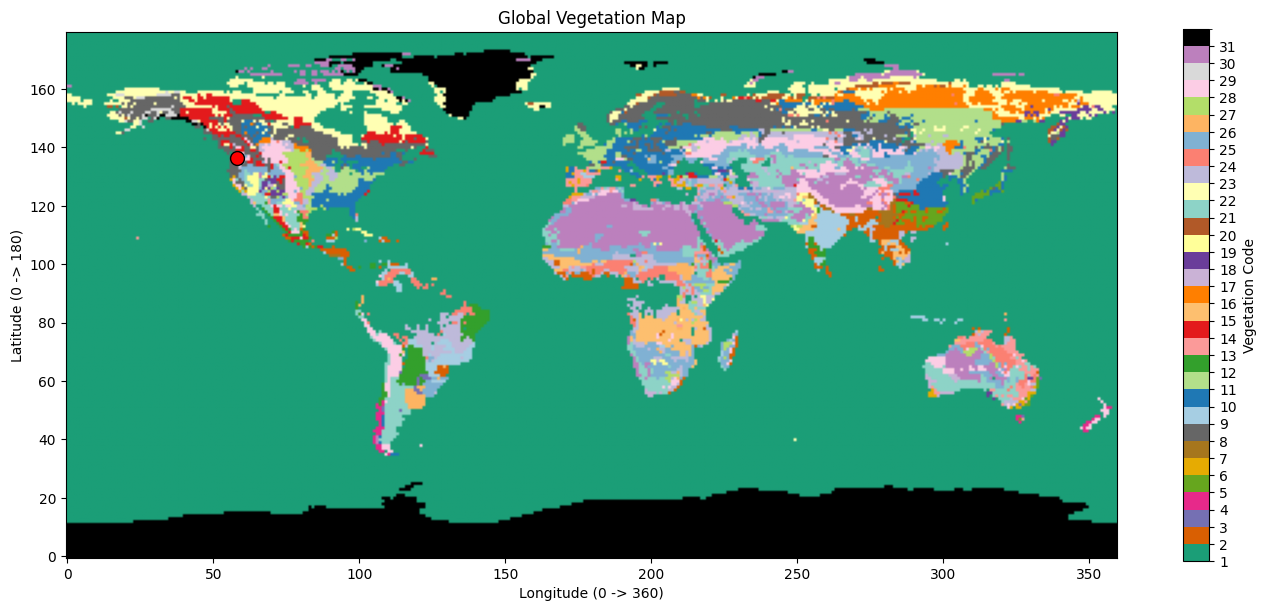

In [28]:
# Load vegetation data from text file
with open("./data_2024/Vegetation.txt", "r") as f:
    lines = f.readlines()

data = []

# Skip first 3 rows (header info)
for line in lines:
    try:
        nums = [int(val) for val in line.strip().split()]
        data.extend(nums)
    except ValueError:
        continue

veg_array = np.array(data[:180 * 360]).reshape((180, 360))

# Give vegetation colors (codes 1–31)
colors = [
    "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e",  
    "#e6ab02", "#a6761d", "#666666", "#a6cee3", "#1f78b4",  
    "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f",  
    "#ff7f00", "#cab2d6", "#6a3d9a", "#ffff99", "#b15928",  
    "#8dd3c7", "#ffffb3", "#bebada", "#fb8072", "#80b1d3",  
    "#fdb462", "#b3de69", "#fccde5", "#d9d9d9", "#bc80bd",  
    "#000000"
]

cmap = ListedColormap(colors)
norm = BoundaryNorm(np.arange(1, 33), cmap.N)

# Vegetation map
plt.figure(figsize = (14, 6))
plt.imshow(veg_array, cmap = cmap, norm = norm, origin = "lower")
plt.title("Global Vegetation Map")
plt.xlabel("Longitude (0 -> 360)")
plt.ylabel("Latitude (0 -> 180)")

cbar = plt.colorbar(ticks = np.arange(1, 32))
cbar.set_label("Vegetation Code")

plt.tight_layout()

plt.scatter(-122 + 180, 47 + 89.5, color = "red", s = 100, edgecolors = "black", marker = "o", label = "Target Point")

plt.show()

In [ ]:
# Add vegetation type to training_data based on coordinate points
cords = ["LAT_MAX", "LAT_MIN", "LON_MAX", "LON_MIN"]
veg_points = ["LAT_MAX_VEG", "LAT_MIN_VEG", "LON_MAX_VEG", "LON_MIN_VEG"]

for col in veg_points:
    training_data[col] = None

for index, row in training_data.iterrows():
    for cord in cords:
        lat = row.get(f"{cord}_LAT")
        lon = row.get(f"{cord}_LON")

# Convert geographic coordinates to array
        convertedLat = int(lat + 89.5)   
        convertedLon = int(lon + 180)    

# Get vegetation type
        veg_type = veg_array[convertedLat, convertedLon]
        training_data.at[index, f"{cord}_VEG"] = veg_type

# Apply one-hot encoding
veg_cols = [col for col in training_data.columns if col.endswith("_VEG")]
training_data_encoded = pd.get_dummies(training_data, columns=veg_cols, prefix_sep='_')

# print(training_data.iloc[1499])

UID                                        32268996
ACQ_DATE                        2024-08-10 00:00:00
LAT_MAX_LAT                                 65.3997
LAT_MAX_LON                               -118.8209
LAT_MIN_LAT                                 65.3997
LAT_MIN_LON                               -118.8209
LON_MAX_LAT                                 65.3997
LON_MAX_LON                               -118.8209
LON_MIN_LAT                                 65.3997
LON_MIN_LON                               -118.8209
ACQ_TIME_MAX_LAT                               0401
ACQ_TIME_MIN_LAT                               0401
ACQ_TIME_MAX_LON                               0401
ACQ_TIME_MIN_LON                               0401
NEXT_LAT_MAX_LAT                            65.4037
NEXT_LAT_MAX_LON                          -118.8282
NEXT_LAT_MIN_LAT                            65.4037
NEXT_LAT_MIN_LON                          -118.8282
NEXT_LON_MAX_LAT                            65.4037
NEXT_LON_MAX

In [ ]:
# Define input features
predictor_cols = [
    "LAT_MAX_LAT", "LAT_MAX_LON", "LAT_MIN_LAT", "LAT_MIN_LON",
    "LON_MAX_LAT", "LON_MAX_LON", "LON_MIN_LAT", "LON_MIN_LON",
]

# Add weather and vegetation columns
weather_cols = [col for col in training_data.columns if any(w in col for w in ["temperature", "humidity", "wind", "precipitation"])]
veg_cols = [col for col in training_data.columns if col.endswith("_VEG")]
predictor_cols.extend(weather_cols + veg_cols)

x = training_data[predictor_cols].astype(float).dropna()
y = pd.DataFrame({
    "DELTA_LAT_MAX_LAT": training_data["NEXT_LAT_MAX_LAT"] - training_data["LAT_MAX_LAT"],
    "DELTA_LAT_MAX_LON": training_data["NEXT_LAT_MAX_LON"] - training_data["LAT_MAX_LON"],
    "DELTA_LAT_MIN_LAT": training_data["NEXT_LAT_MIN_LAT"] - training_data["LAT_MIN_LAT"],
    "DELTA_LAT_MIN_LON": training_data["NEXT_LAT_MIN_LON"] - training_data["LAT_MIN_LON"],
    "DELTA_LON_MAX_LAT": training_data["NEXT_LON_MAX_LAT"] - training_data["LON_MAX_LAT"],
    "DELTA_LON_MAX_LON": training_data["NEXT_LON_MAX_LON"] - training_data["LON_MAX_LON"],
    "DELTA_LON_MIN_LAT": training_data["NEXT_LON_MIN_LAT"] - training_data["LON_MIN_LAT"],
    "DELTA_LON_MIN_LON": training_data["NEXT_LON_MIN_LON"] - training_data["LON_MIN_LON"]
}).loc[x.index]


# 5-fold valudation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_per_output = {col: [] for col in y.columns}

for train_idx, val_idx in kf.split(x):
    x_train_cv, x_val_cv = x.iloc[train_idx], x.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    y_scaler = StandardScaler()
    y_train_cv_scaled = y_scaler.fit_transform(y_train_cv)

# Train model
    model_cv = MultiOutputRegressor(
        xgb.XGBRegressor(objective="reg:squarederror", random_state=0)
    )
    model_cv.fit(x_train_cv, y_train_cv_scaled)

    y_pred_scaled = model_cv.predict(x_val_cv)
    y_pred_cv = y_scaler.inverse_transform(y_pred_scaled)

# Compute RMSE for each output
    for i, col in enumerate(y.columns):
        rmse = np.sqrt(mean_squared_error(y_val_cv.iloc[:, i], y_pred_cv[:, i]))
        rmse_per_output[col].append(rmse)


# print("RMSE per Δ-coordinate (averaged across 5 folds):")
for col in y.columns:
    avg_rmse = np.mean(rmse_per_output[col])
    std_rmse = np.std(rmse_per_output[col])
    # print(f"{col}: {avg_rmse:.4f} ± {std_rmse:.4f}")

RMSE per Δ-coordinate (averaged across 5 folds):
DELTA_LAT_MAX_LAT: 0.0825 ± 0.0063
DELTA_LAT_MAX_LON: 0.1313 ± 0.0068
DELTA_LAT_MIN_LAT: 0.0857 ± 0.0071
DELTA_LAT_MIN_LON: 0.1443 ± 0.0111
DELTA_LON_MAX_LAT: 0.0892 ± 0.0083
DELTA_LON_MAX_LON: 0.1288 ± 0.0081
DELTA_LON_MIN_LAT: 0.0930 ± 0.0056
DELTA_LON_MIN_LON: 0.1272 ± 0.0090


In [31]:
# pickle.dump(model, open("spread_model.pkl", "wb"))

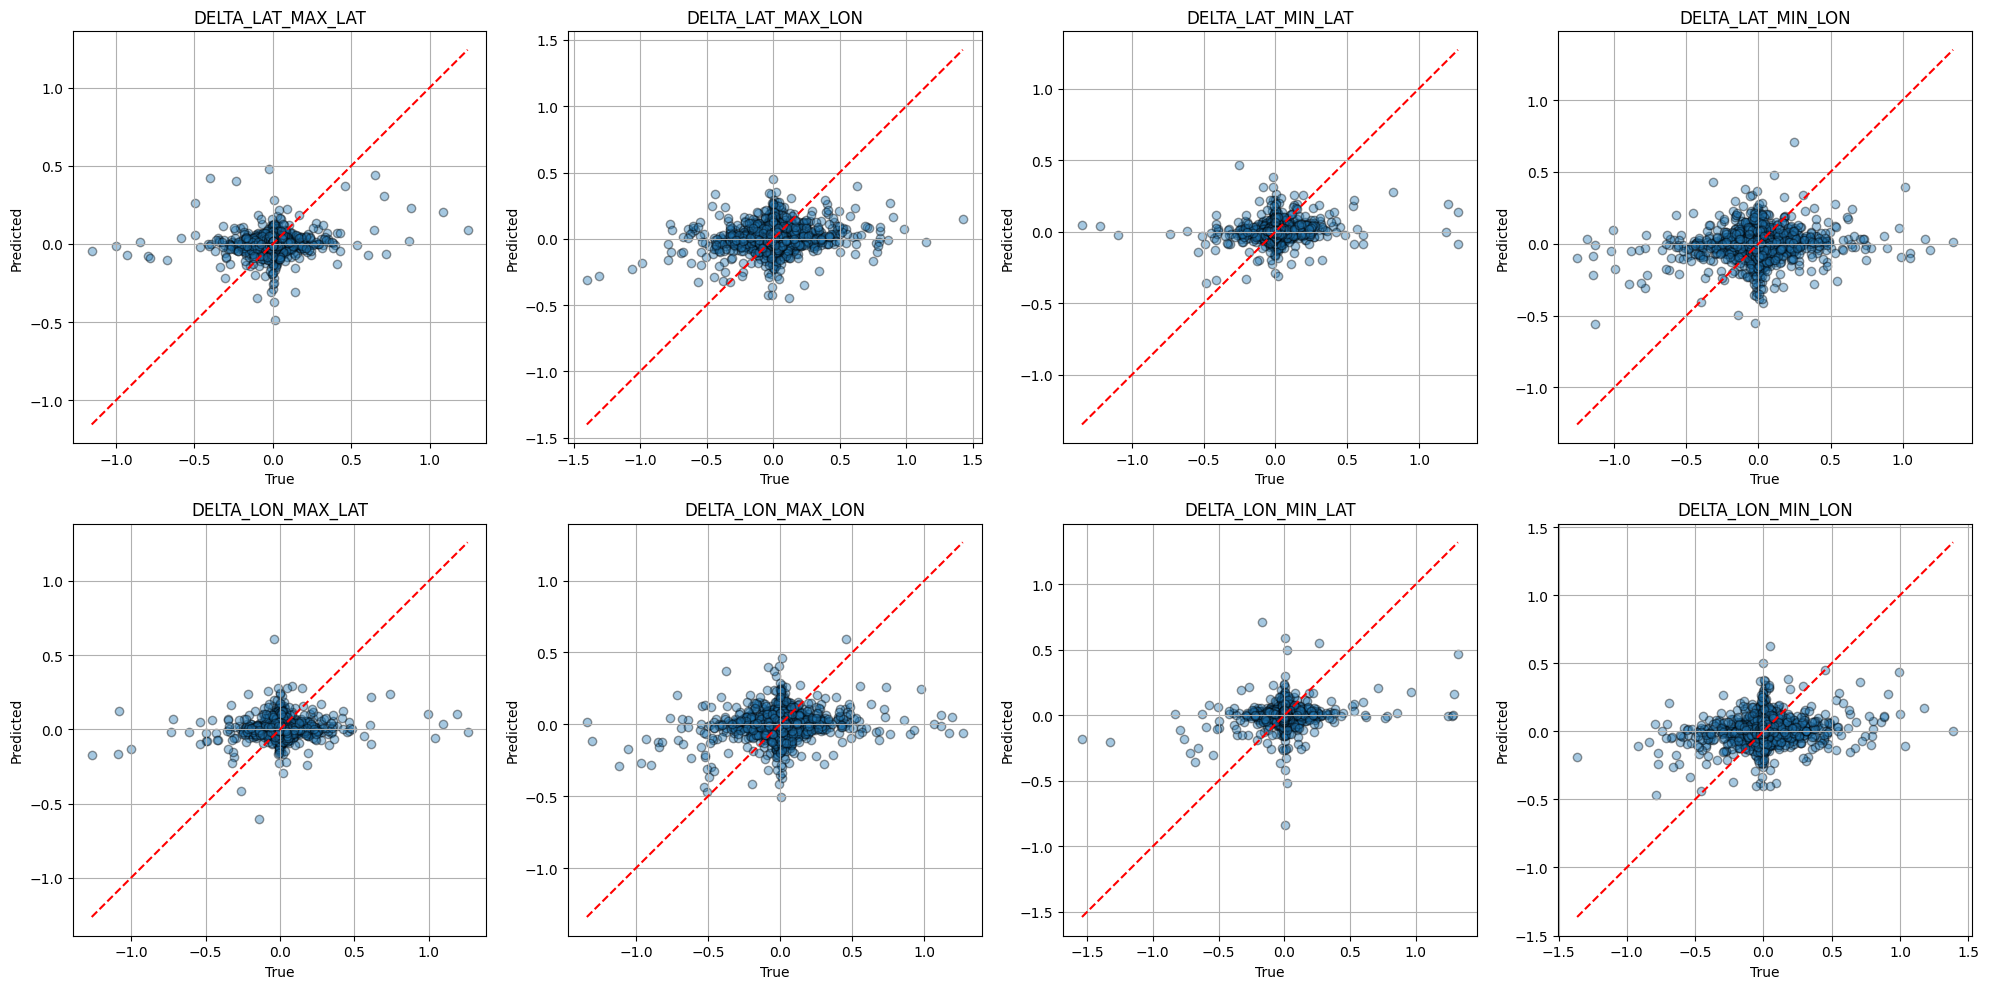

In [36]:
# Plot all outputs
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, col in enumerate(y.columns):
    ax = axes[i // 4, i % 4]
    ax.scatter(y_val_all[col], y_pred_all[col], alpha=0.4, edgecolors = "k")
    ax.plot([y_val_all[col].min(), y_val_all[col].max()],
            [y_val_all[col].min(), y_val_all[col].max()], "r--")
    ax.set_title(col)
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")
    ax.grid(True)
plt.tight_layout()
plt.show()